## Welcome

This is material for the **Potential Outcomes** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import random

In [2]:
np.random.seed(91)
random.seed(91)

### Statistical Inference

In [3]:
url = 'https://github.com/scunning1975/mixtape/raw/master/yule.dta'
yule = pd.read_stata(url)

In [4]:
res = sm.OLS.from_formula('paup ~ outrelief + old + pop', data = yule).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   paup   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     21.49
Date:                Sat, 25 Dec 2021   Prob (F-statistic):           2.00e-07
Time:                        21:57:56   Log-Likelihood:                -115.47
No. Observations:                  32   AIC:                             238.9
Df Residuals:                      28   BIC:                             244.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.1877     27.144      2.328      0.0

#### Questions

- How do you interpret the coefficient on `outrelief` given it's a percentage change regressed onto a percentage?
- Draw a DAG representing what must be true in order for Yule's estimate of `outrelief` on pauper growth rates to be causal?  
- Yule concluded that public assistance (`outrelief`) increased pauper growth rates. How convinced are you that all backdoor paths between pauperism and out-relief are blocked once you control for two covariates in a cross-sectional database for all of England? Could there be unobserved determinants of both poverty and public assistance?
- If public assistance causes pauper growth rates, but pauper growth rates also causes public assistance, then why won't Yule's regression capture a causal effect of `outrelief` on pauper growth rates?  Explain the concept of reverse causality with Yule's data.

### Independence Assumption

In [5]:
y1 = 7, 5, 5, 7, 4, 10, 1, 5, 3, 9
y1 = np.array(y1)
y0 = 1, 6, 1, 8, 2, 1, 10, 6, 7, 8
y0 = np.array(y0)

sdo_list = list()
for sim in range(10000):

    # Initialize treatment 1111100000
    d = np.concatenate([np.ones(5), np.zeros(5)])
    # Shuffle treatment randomly
    random.shuffle(d)
    # Pull y1 or y0 depending on treatment
    y = d*y1 + (1-d)*y0

    # means
    sy1 = np.mean(y[d==1]) # index y where d = 1
    sy0 = np.mean(y[d==0]) # index y where d = 0
    sdo = sy1 - sy0
    
    sdo_list.append(sdo)

In [6]:
print('SDO', np.mean(sdo_list))

SDO 0.59042


In [7]:
ate = np.mean(y1 - y0)
print('ATE', ate)

ATE 0.6


#### Questions
- The requirement that treatment be independent of potential outcomes states that a choice made by a person must be independent of what they expect to gain or lose from the choice.  Give an example where this is likely true?  What does independence imply about human decision-making?
- All of the behavioral sciences, including economics, suggest that independence is unlikely to hold outside of an experiment. What is so special about an experiment where independence will hold?  What is so special about behavior outside an experiment where it is unlikely to hold?
- What implication does the decision rule of utility maximization from economics have for our ability to appeal to treatment being distributed independent of potential outcomes?





## Fisher Randomization

In [8]:
from itertools import combinations

In [9]:
# 8 cups of tea, assume she guesses the first four cups
guess = (1,2,3,4)

n_combos = 0
correct = 0
for truth in combinations(range(1,9), 4): # possible placement of the four cups
    n_combos += 1 # add one to count of combinations
    if truth == guess:
        correct += 1

In [10]:
print('probability of guessing the truth', correct/n_combos)

probability of guessing the truth 0.014285714285714285


#### Questions

- Using the above simulation, what is the probability that Dr. Bristol selected the correct four cups completely by chance?

## Randomization Inference

### Fisher Sharp Null

In [11]:
url = 'https://github.com/scunning1975/mixtape/raw/master/ri.dta'
ri = pd.read_stata(url, index_col = 'name')

In [14]:
test_stat_helper = ri.groupby('d').y.mean()
observed_test_stat = test_stat_helper[1] - test_stat_helper[0]
print(observed_test_stat)

1.0


In [15]:
# sharp null

# randomly assign d = 1
assignment_table = pd.DataFrame()
for key, assignment in enumerate(combinations(ri.index, 4)):
    control = [x for x in ri.index if x not in assignment] # those not in treatment group
    mean_treated = ri.loc[list(assignment),'y'].mean()
    mean_u = ri.loc[control, 'y'].mean()
    
    test_stat = np.abs(mean_treated - mean_u)
    
    # dicts
    dict1 = dict(zip(assignment,np.ones(4)))
    dict2 = dict(zip(control, np.zeros(4)))
    dict3 = {'t_stat': test_stat}
    dict1.update(dict2)
    dict1.update(dict3)
    row = pd.DataFrame(data = dict1, index = [key])
    
    assignment_table = assignment_table.append(row)

In [16]:
p_value = (assignment_table.t_stat >= observed_test_stat).mean()
print(p_value) # two-sided p-value

0.8571428571428571


In [17]:
# do it again with permutations instead of combinations
from itertools import permutations

y_vec = ri.y.values 
d = np.concatenate( [np.ones(4), (-1)*np.ones(4)] )
t_stats = list()
for d_vec in permutations(d):    
    t = np.abs( np.dot(y_vec, d_vec) / 4 )
    t_stats.append(t)

In [18]:
p_value = (t_stats >= observed_test_stat).mean()


In [19]:
p_value

0.8571428571428571

#### Questions

- Can we reject the null in the placebo distribution?



### KS Test


In [20]:
tb = pd.DataFrame({
    'd' : np.concatenate((np.repeat(0, 20), np.repeat(1, 20))),
    'y' : (
        0.22, -0.87, -2.39, -1.79, 0.37, -1.54,
        1.28, -0.31, -0.74, 1.72,
        0.38, -0.17, -0.62, -1.10, 0.30,
        0.15, 2.30, 0.19, -0.50, -0.9,
        -5.13, -2.19, 2.43, -3.83, 0.5,
        -3.25, 4.32, 1.63, 5.18, -0.43,
        7.11, 4.87, -3.10, -5.81, 3.76,
        6.31, 2.58, 0.07, 5.76, 3.50
    )})

Text(0.5, 0, 'y')

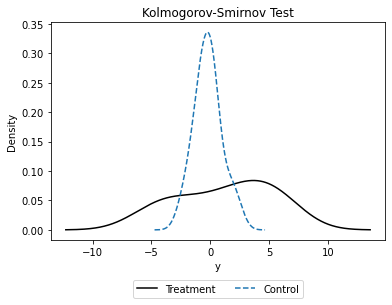

In [21]:
fig, ax = plt.subplots()

tb[tb.d == 1].y.plot(kind = 'density', ax = ax, label = 'Treatment', color = 'black')
tb[tb.d == 0].y.plot(kind = 'density', ax = ax, label = 'Control', linestyle = 'dashed')
ax.legend(loc = 'lower center', bbox_to_anchor = (0.5, -.29), ncol = 2)

ax.set_title("Kolmogorov-Smirnov Test")
ax.set_xlabel("y")

## Approximate $p$-values

In [22]:
url = "https://github.com/scunning1975/mixtape/raw/master/thornton_hiv.dta"

hiv = pd.read_stata(url)

In [23]:
hiv['any'].value_counts()

1.0    2222
0.0     679
Name: any, dtype: int64

In [26]:
grouped_means = hiv.groupby("any").got.mean()

# ATE in the data
ate = grouped_means.loc[1] - grouped_means.loc[0]

In [27]:
print(ate)

0.45055187


In [28]:
hiv_in_sample = hiv[hiv['any'].isin([0,1])]
ate_list = [ate]

for simulation in range(999):
    
    # randomize and take first 2222 rows in alternate treatment
    shuffled = hiv_in_sample.sample(frac = 1)
    shuffled['alt_any'] = np.concatenate([np.ones(2222),np.zeros(2901-2222)])
    
    grouped_means = shuffled.groupby('alt_any').got.mean()
    ate_alt = grouped_means.loc[1] - grouped_means.loc[0]
    ate_list.append(ate_alt)

In [29]:
rank = len([x for x in ate_list if x >= ate])
p_value = rank / len(ate_list)

In [30]:
print(rank, p_value)

1 0.001


#### Questions 

- How does the randomization inference test of no treatment effect differ from a null of no average treatment effect?
- How likely is it that Thornton's results were a result of random chance? 